# RTI International Analytics Exercise
### Author: Sam Eure
### Date: May 31, 2019

In [4]:
#SQLite query onsolidating the data into a single table using inner joins
#This query was first tested/created in the SQLite Manager environment within Firefox 67.0

import sqlite3

conn = sqlite3.connect('exercise01.sqlite')
cur = conn.cursor()
query = cur.execute('SELECT records.id, records.over_50k, records.education_num, \
                        records.capital_gain, records.capital_loss, records.hours_week, records.age,\
                        workclasses.name AS workclass, \
                        education_levels.name AS education_level,\
                        marital_statuses.name AS marital_status,\
                        occupations.name AS occupation,\
                        relationships.name AS relationship,\
                        races.name AS race,\
                        sexes.name AS sex,\
                        countries.name AS country\
                        FROM records\
                        INNER JOIN workclasses ON workclasses.id = records.workclass_id\
                        INNER JOIN education_levels ON education_levels.id = records.education_level_id\
                        INNER JOIN marital_statuses ON marital_statuses.id = records.marital_status_id\
                        INNER JOIN occupations ON occupations.id = records.occupation_id\
                        INNER JOIN relationships ON relationships.id = records.relationship_id\
                        INNER JOIN races ON races.id = records.race_id\
                        INNER JOIN sexes ON sexes.id = records.sex_id\
                        INNER JOIN countries ON countries.id = records.country_id;').fetchall()

In [5]:
import pandas as pd
import numpy as np

#Turn the list of the output from the query into a dataframe

columnNames = ["id","over_50k","education_num","capital_gain","capital_loss",
                "hours_week","age","workclass","education_level","marital_status",
                 "occupation","relationship","race","sex","country"]
df = pd.DataFrame(data = query, columns = columnNames)

#Column Headers


df.columns = columnNames

#Saving the data to a CSV
df.to_csv("data.csv", sep = ',', index = False)

#Showing the results
df.head()

,id,over_50k,education_num,capital_gain,capital_loss,hours_week,age,workclass,education_level,marital_status,occupation,relationship,race,sex,country
0,1,0,13,2174,0,40,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,2,0,13,0,0,13,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,3,0,9,0,0,40,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,4,0,7,0,0,40,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,5,0,13,0,0,40,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [6]:
#Now I'll look at the data types
df.dtypes

id                  int64
over_50k            int64
education_num       int64
capital_gain        int64
capital_loss        int64
hours_week          int64
age                 int64
workclass          object
education_level    object
marital_status     object
occupation         object
relationship       object
race               object
sex                object
country            object
dtype: object

In [7]:
#Fraction of workers that make over 50k
1.0 - np.mean(df.over_50k.tolist())

0.7607182343065395

In [8]:
#I'm going to grab only the rows with NO missing values. This will be a DataFrame with complete entries.
completeDf = df.copy()
for c in columnNames:
    completeDf = completeDf[completeDf[c].apply(lambda v: v != "?")]
print("Number of complete entries: ", len(completeDf))
print("Number of incomplete entries:", len(df) - len(completeDf))

Number of complete entries:  45222
Number of incomplete entries: 3620


It seems that around 92.5% of the entries are complete. 

In [10]:
#Fraction of complete workers that make over 50k
1.0 - np.mean(completeDf.over_50k.tolist())

0.7521560302507629

It also seems that the fraction of workers with complete data entries that make over 50K is similar to that of all workers since they differ by less than one percent and the fraction is already pretty high (around 3/4th). 

## -------------------------------
## -------------------------------
# Exploratory Data Analysis
## -------------------------------
## -------------------------------

### First, I'll plot the fraction of workers that make over 50k/year vs. their census variables.

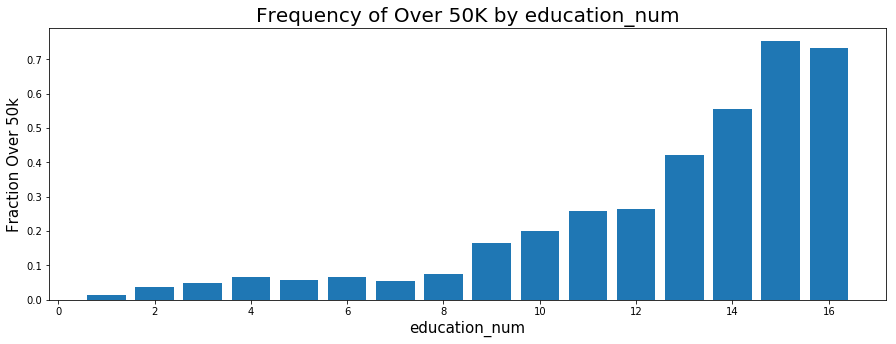

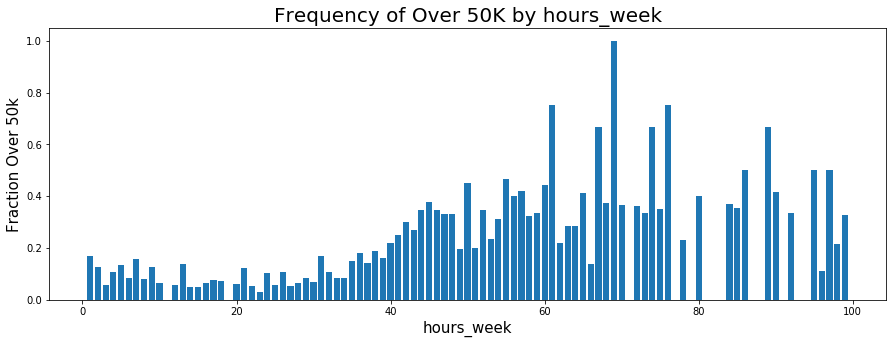

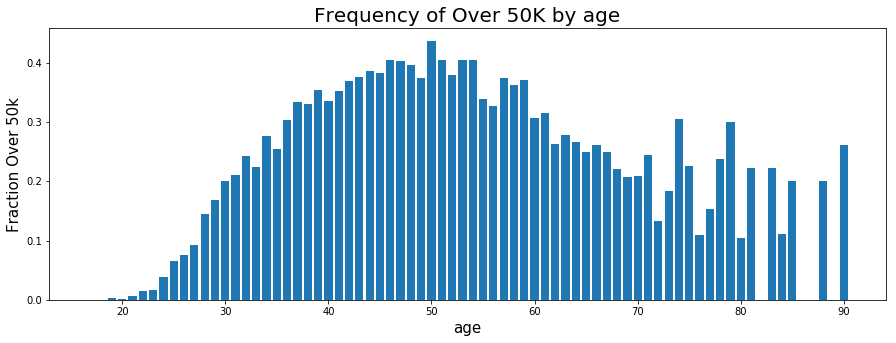

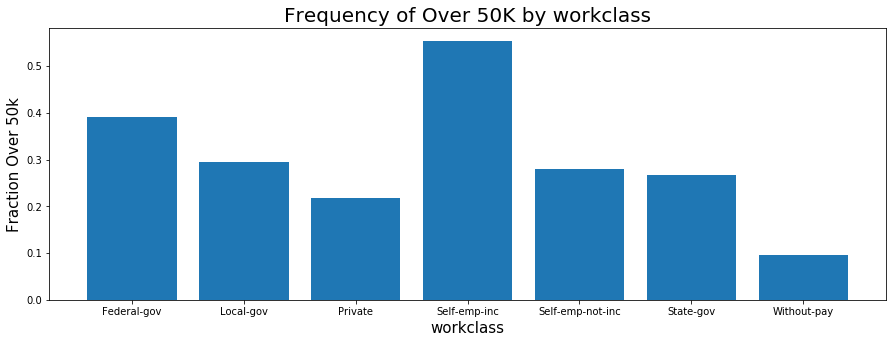

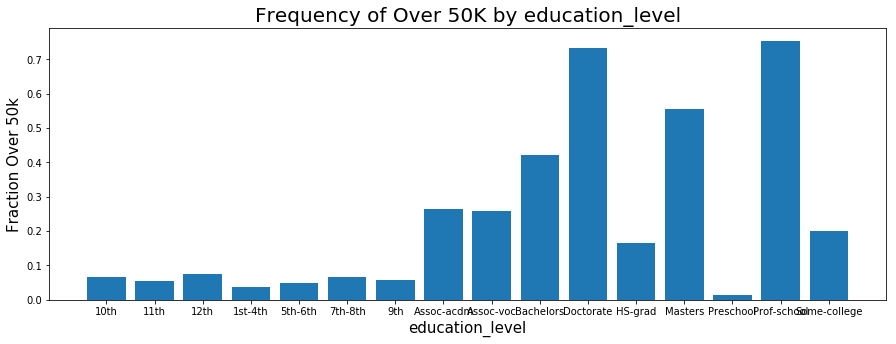

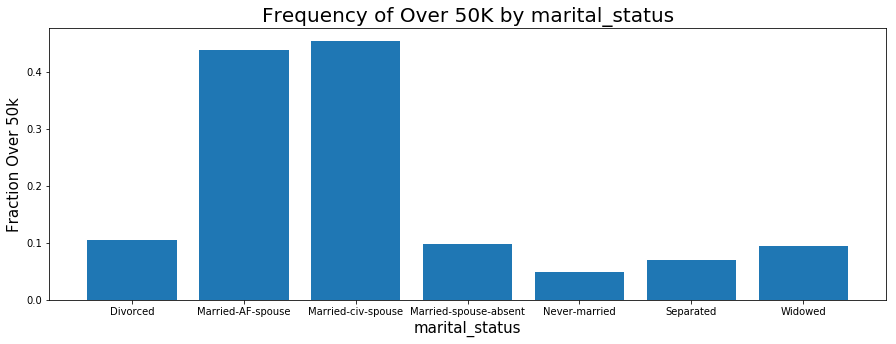

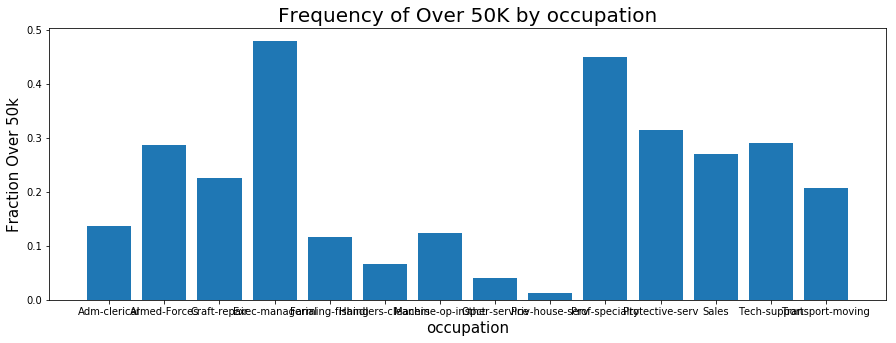

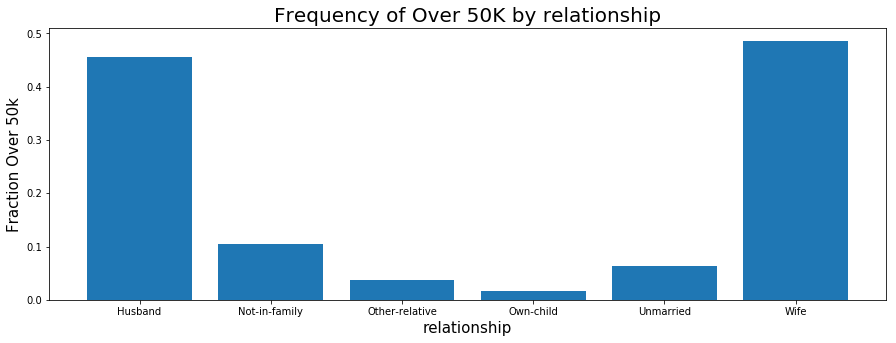

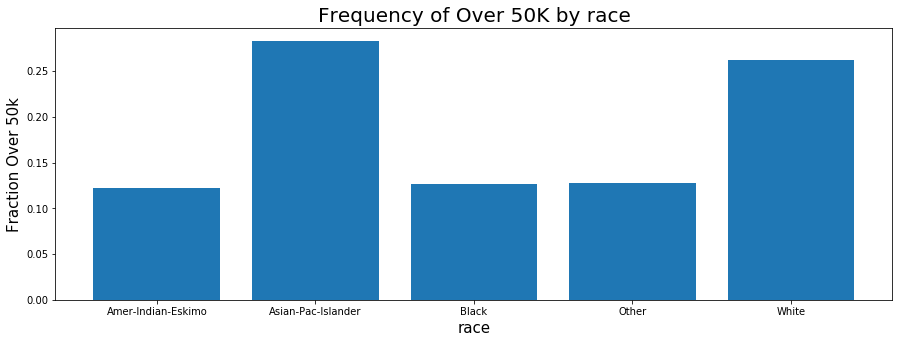

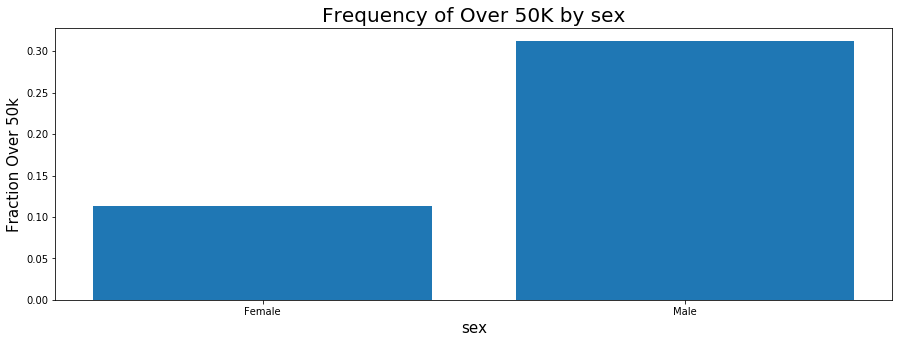

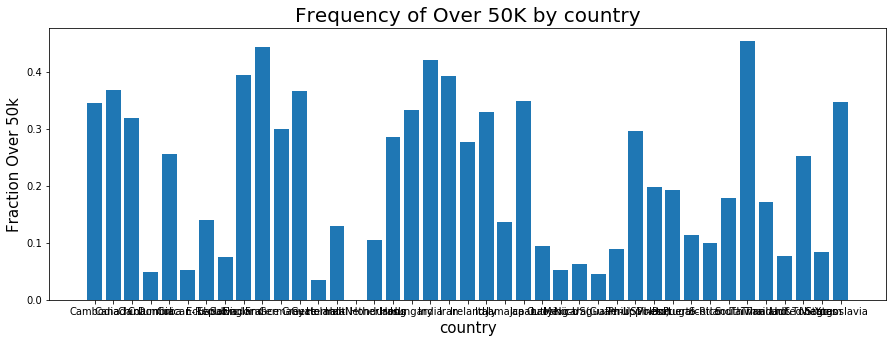

In [15]:
import matplotlib.pyplot as plt

columns = completeDf.columns.tolist()
for j in range(len(columns)):
    if columns[j] in 'id, capital_gain, capital_loss, over_50k':
        continue;
    means = completeDf.groupby(columns[j]).mean().over_50k.tolist()
    names = completeDf[columns[j]].unique().tolist()
    names.sort()
    fig = plt.figure(figsize = (15,5))
    plt.bar(names,means)
    plt.title("Frequency of Over 50K by "+columns[j], fontsize = 20)
    plt.xlabel(columns[j], fontsize = 15)
    plt.ylabel("Fraction Over 50k", fontsize = 15)

#### Although I can't see what the labels at the bottom of all the figures above state (especially the fraction over 50k vs country figure), I can tell that the frequency of workers making over 50K a year depend on the variables being plotted.

#### Next, I'll investigate whether the distribution of census level features differ between those who earn over 50k and those who do not. 

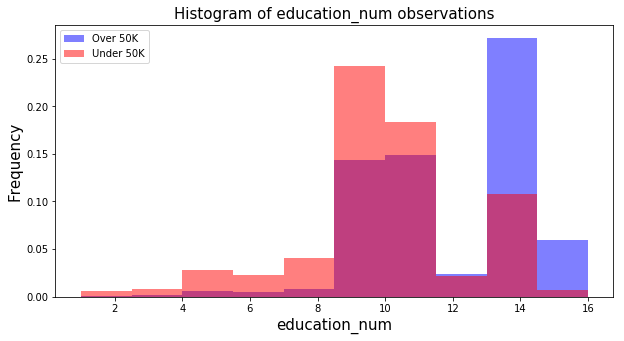

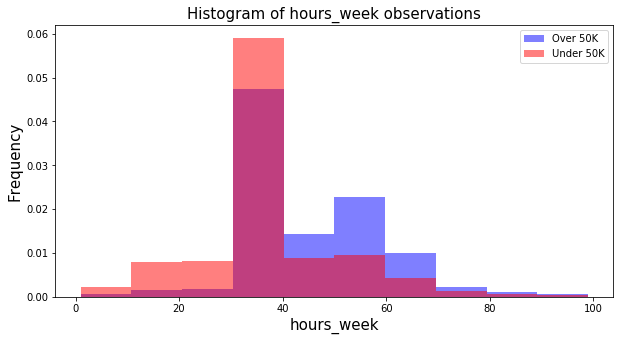

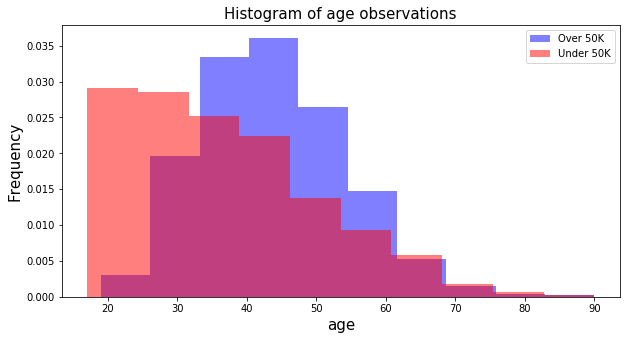

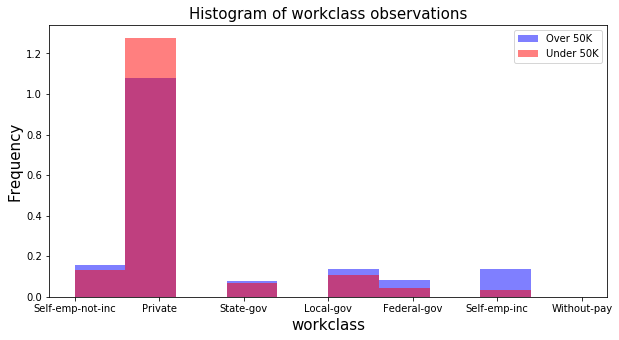

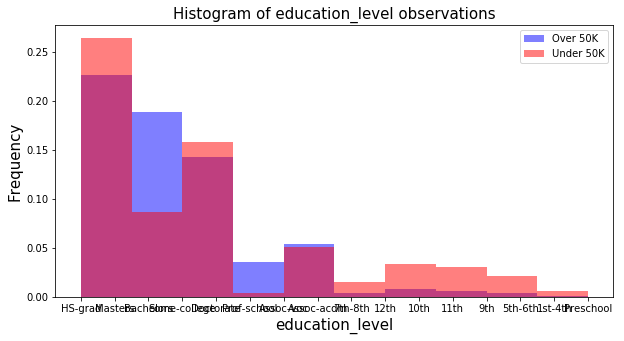

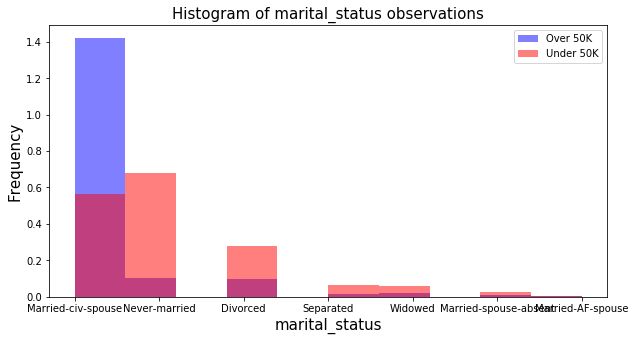

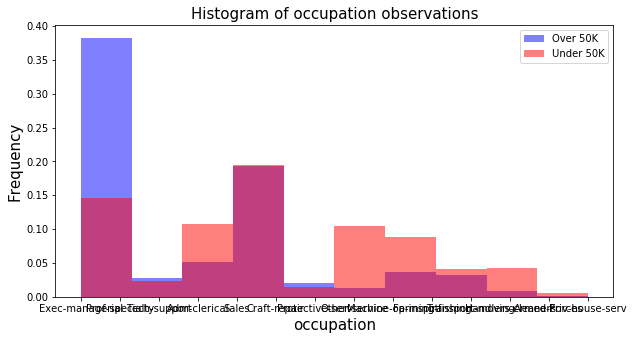

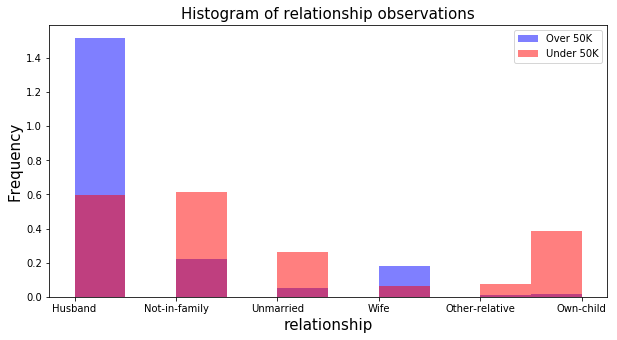

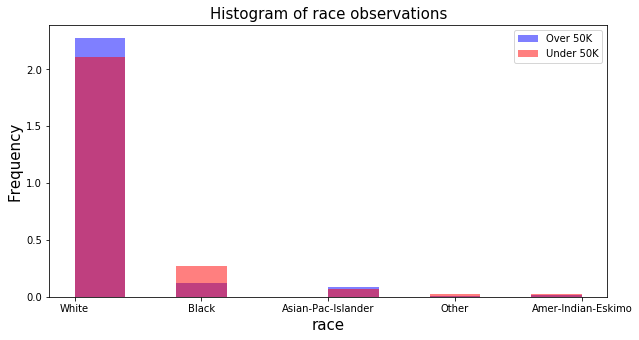

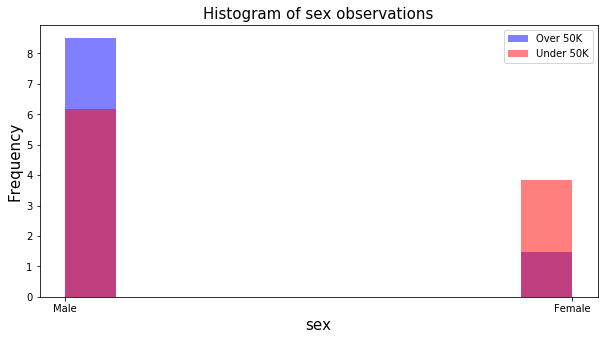

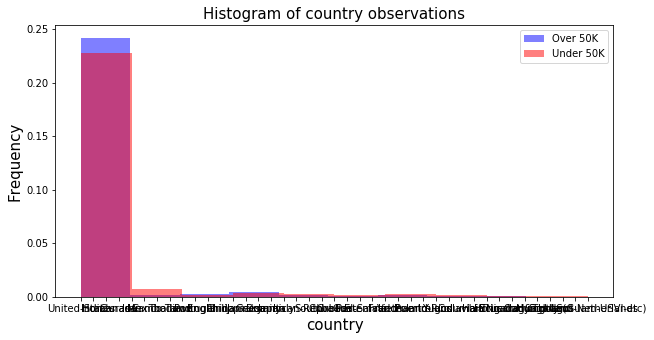

In [30]:
overDf  = completeDf[completeDf['over_50k'] == 1]
underDf = completeDf[completeDf['over_50k'] == 0]

for j in range(len(columns)):
    if columns[j] in 'id, capital_gain, capital_loss, over_50k':
        continue;
        
    fracOverList  = overDf[columns[j]].tolist()
    fracUnderList = underDf[columns[j]].tolist()
    fig = plt.figure(figsize = (10,5))
    plt.hist(fracOverList, label = 'Over 50K', color = 'blue', alpha  = 0.5, density = True)
    plt.hist(fracUnderList, label = 'Under 50K', color = 'Red', alpha = 0.5, density = True)
    plt.title("Histogram of "+columns[j] +" observations", fontsize = 15)
    plt.xlabel(columns[j], fontsize = 15)
    plt.ylabel("Frequency", fontsize = 15)
    plt.legend()

*** There seem to be clear differences in the distribution of the variables relationship/marital status, sex, occupation, and education_level/education_num, and hours_week between the two groups.  ***

## -------------------------------
## -------------------------------
# Data Preprocessing
## -------------------------------
## -------------------------------

#### I'll use some ML techniques to create a classification model for determining if an individual earns over 50 K dollars a year based on their census level data.#### To handle categorical variables, I'll use one hot encoding. 

In [35]:
colIndex = list(set(columns) - {'id', 'education_level'})
cleanDf = completeDf[colIndex]
cleanDf.head()

,age,marital_status,capital_loss,over_50k,workclass,relationship,education_num,occupation,country,hours_week,race,capital_gain,sex
0,39,Never-married,0,0,State-gov,Not-in-family,13,Adm-clerical,United-States,40,White,2174,Male
1,50,Married-civ-spouse,0,0,Self-emp-not-inc,Husband,13,Exec-managerial,United-States,13,White,0,Male
2,38,Divorced,0,0,Private,Not-in-family,9,Handlers-cleaners,United-States,40,White,0,Male
3,53,Married-civ-spouse,0,0,Private,Husband,7,Handlers-cleaners,United-States,40,Black,0,Male
4,28,Married-civ-spouse,0,0,Private,Wife,13,Prof-specialty,Cuba,40,Black,0,Female


#### One Hot Encoding

In [36]:
hotCleanDf = pd.get_dummies(cleanDf)
print("Now I Have ",len(hotCleanDf.columns), " features instead of ", len(cleanDf.columns), "features. \n\n hotCleanDf.head()")
hotCleanDf.head()

Now I Have  88  features instead of  13 features. 

 hotCleanDf.head()


,age,capital_loss,over_50k,education_num,hours_week,capital_gain,marital_status_Divorced,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,...,country_United-States,country_Vietnam,country_Yugoslavia,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,39,0,0,13,40,2174,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,50,0,0,13,13,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
2,38,0,0,9,40,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,53,0,0,7,40,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
4,28,0,0,13,40,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


#### Next, I'll divide my data set into a train, validation, and test data sets. I'll used the cleanDf (which is contains the data points with complete entries) as my data set.

In [37]:
import random

random.seed(1)
indices = list(range(len(cleanDf)))
random.shuffle(indices)
hotCleanDf = hotCleanDf.iloc[indices,:] #shuffling the data points

predictors = hotCleanDf.columns.tolist().copy()
predictors.remove('over_50k')

#Splitting the data set into training, validation, and testing data sets. 
sixty = round(0.6*len(hotCleanDf)) #The number of data points comprising roughly eighty % of the data. 
eighty = round(0.8*len(hotCleanDf))
trainX, trainY = hotCleanDf[predictors].iloc[:sixty,:],           hotCleanDf['over_50k'].iloc[:sixty]
valX,   valY   = hotCleanDf[predictors].iloc[sixty:eighty,:], hotCleanDf['over_50k'].iloc[sixty:eighty]
testX,  testY  = hotCleanDf[predictors].iloc[eighty:,:],          hotCleanDf['over_50k'].iloc[eighty:]

print("Size of training data:  ", len(trainX))
print("Size of validation data:", len(valX))
print("Size of testing data:   ", len(testX))

Size of training data:   27133
Size of validation data: 9045
Size of testing data:    9044


## -------------------------------
## -------------------------------
# Creating Models
## -------------------------------
## -------------------------------

### Random Forest Classifier

Training took 0 seconds using 2 trees
Training took 0 seconds using 4 trees
Training took 0 seconds using 8 trees
Training took 1 seconds using 16 trees
Training took 1 seconds using 32 trees
Training took 2 seconds using 64 trees
Training took 4 seconds using 128 trees
Training took 8 seconds using 256 trees
Training took 13 seconds using 512 trees
Training took 23 seconds using 1024 trees

 Top Validation Acc: 0.844 using 512 trees.


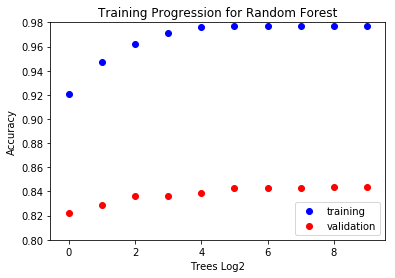

In [38]:
import time
from sklearn.ensemble import RandomForestClassifier
import numpy as np

trees = list(pow(2,np.linspace(1,10,10, dtype = int)))

trainAcc = []
valAcc   = []

for decision_trees_used in trees:
    start = time.time()
    rfc = RandomForestClassifier(n_estimators = decision_trees_used,
                                 n_jobs = -1)
    rfc.fit(trainX, trainY)
    finish = time.time()
    print("Training took",round(finish-start),'seconds using', decision_trees_used, 'trees')
    trainAcc.append(round(rfc.score(trainX, trainY),3))
    valAcc.append(round(rfc.score(valX, valY),3))
    
plt.ylim([0.80,0.98])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training')
plt.scatter(list(range(len(valAcc))), valAcc, color = 'red', label = 'validation')
plt.ylabel("Accuracy")
plt.xlabel("Trees Log2")
plt.title("Training Progression for Random Forest")
plt.legend(loc = 'lower right')
print("\n Top Validation Acc:", round(max(valAcc),3), 'using', trees[np.argmax(valAcc)], 'trees.')

### Logistic Regression

#### Vanilla

In [63]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'liblinear')
lr.fit(trainX, trainY)
print("Training Acc:  ",round(lr.score(trainX, trainY),3))
print("Validation Acc:",round(lr.score(valX, valY),3))
print("Test Acc:      ",round(lr.score(testX, testY),3))

Training Acc:   0.848
Validation Acc: 0.846
Test Acc:       0.845


#### Ridge

Max validation Acc: 0.8472 using regularization strength of 0.05


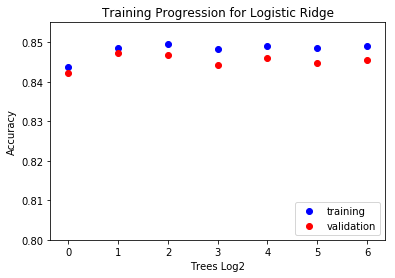

In [64]:
trainAcc = []
valAcc = []
Cs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]  #Inverse of regression strength
for c in Cs:
    lr = LogisticRegression(penalty = 'l2', C = c, solver = 'liblinear')
    lr.fit(trainX, trainY)
    trainAcc.append(round(lr.score(trainX, trainY),4))
    valAcc.append(round(lr.score(valX, valY),4))
plt.ylim([0.80,0.855])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training')
plt.scatter(list(range(len(valAcc))),   valAcc,   color = 'red',  label = 'validation')
plt.ylabel("Accuracy")
plt.xlabel("Trees Log2")
plt.title("Training Progression for Logistic Ridge")
plt.legend(loc = 'lower right')
print("Max validation Acc:", max(valAcc), "using regularization strength of", Cs[np.argmax(valAcc)])

In [65]:
#Final accuracy using Logistic Ridge Regression
lr = LogisticRegression(penalty = 'l2', C = Cs[np.argmax(valAcc)], solver = 'liblinear')
lr.fit(trainX, trainY)
print("Test Accuracy of",round(lr.score(testX, testY),4))

Test Accuracy of 0.8452


#### LASSO

Max validation Acc: 0.8461 using regularization strength of 1.0


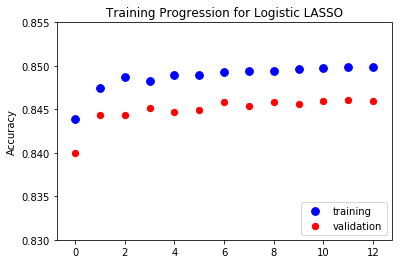

In [66]:
trainAcc = []
valAcc = []
Cs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]  #Inverse of regression strength
for c in Cs:
    lr = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear')
    lr.fit(trainX, trainY)
    trainAcc.append(round(lr.score(trainX, trainY), 4))
    valAcc.append(  round(lr.score(valX,  valY),  4))
plt.ylim([0.83,.855])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training',   s = 60)
plt.scatter(list(range(len(valAcc))),   valAcc,   color = 'red',  label = 'validation', s = 40)
plt.ylabel("Accuracy")
plt.title("Training Progression for Logistic LASSO")
plt.legend(loc = 'lower right')
print("Max validation Acc:", max(valAcc), "using regularization strength of", Cs[np.argmax(valAcc)])

In [67]:
#Final accuracy using Logistic LASSO Regression
lr = LogisticRegression(penalty = 'l1', C = Cs[np.argmax(valAcc)], solver = 'liblinear')
lr.fit(trainX, trainY)
print("Test Accuracy of",round(lr.score(testX, testY),4))

Test Accuracy of 0.8491


### Given my models, the Logistic Regression using an L-1 Norm regularization method appears to give the highest test accuracy of 84.9%.  This method essentially plots the data points (observations) in a high dimentionally space and draws a decision boundary between the data points while allowing the model to remain skeptical of the data points. 